In [1]:
import openfret
import metasim
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Read dataset
 - Here, we load a dataset in OpenFRET format.
 - The dataset is from paper: Blanco, M. R. et al. Single Molecule Cluster Analysis Identifies Signature Dynamic Conformations along the
Splicing Pathway. Nat. Methods 12, 1077–1084 (2015). 
 - To learn more about the OpenFRET data specification, please visit this [link](https://github.com/simol-lab/OpenFRET).

In [2]:
dataset = openfret.read_data('simcan.json')
dataset = metasim.fret.data.TwoColorDataset(dataset)

# Global Atlas UMAP

We study the dataset first with the global Atlas UMAP, which is a large UMAP model trained with one million annotated synthetic FRET traces.

The naming of Atlas annotation uses the following pattern: state_number-noise_level-FRET_efficiency_buckets-kinetic_rate_buckets
 
 - state_number: A digit ranging from 1 to 3.
 - noise_level: (n)oisy or (c)lean
 - FRET_efficiency_buckets: (low), (medium) or (high)
 - kinetic_rate_buckets: (s)low or (f)ast

For example, 2-c-mh-f is the annotation for traces with 2 states, low noise level, fast kinetic rate. One state's FRET efficiency is in the medium and the other's is high.

In [3]:
label = np.array([
    trace.metadata['experimental_condition']
    for trace in dataset.traces
])

# We need to clean and group a few different labels.
# If you don't need to modify the label, just comment out the line below.
label = np.array([l.replace('Late', '').replace('Middle', '').replace('Early', '').replace('Mid', '').replace('early', '') for l in label])

# Generate META-SiM embedding
model = metasim.fret.Model()
with tf.device('/CPU:0'):  # Most laptops have slower GPU.
    embedding = model.encode(dataset)

# Get the local shannon entropy
entropy = metasim.fret.get_entropy(
    embedding,
    label,
)

  0%|          | 0/6805 [00:00<?, ?it/s]

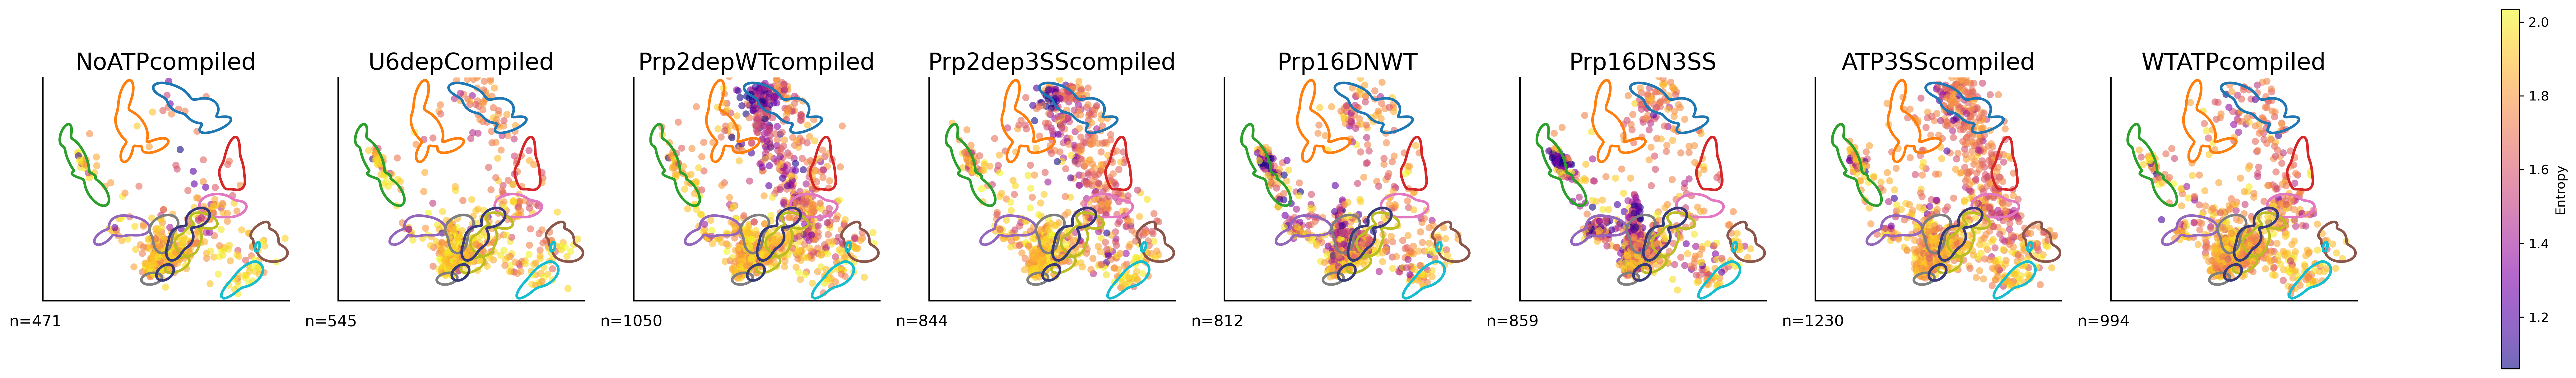

In [16]:
# We would like to plot the UMAPs in the follow sequence
label_order = [
    'NoATPcompiled',
    'U6depCompiled',
    'Prp2depWTcompiled',
    'Prp2dep3SScompiled',
    'Prp16DNWT',
    'Prp16DN3SS',
    'ATP3SScompiled',
    'WTATPcompiled',
]

metasim.fret.tools.viz.plot_atlas(
    embedding=embedding,
    label=label,
    color=entropy,
    color_name='Entropy',
    label_order=label_order,
)
plt.savefig('/tmp/fig.svg')
plt.show()

In [ ]:
# We would like to plot the UMAPs in the follow sequence
label_order = [
    'NoATPcompiled',
    'U6depCompiled',
    'Prp2depWTcompiled',
    'Prp2dep3SScompiled',
    'Prp16DNWT',
    'Prp16DN3SS',
    'ATP3SScompiled',
    'WTATPcompiled',
]

metasim.fret.tools.viz.plot_atlas(
    embedding=embedding,
    label=label,
    color=entropy,
    color_name='Entropy',
    label_order=label_order,
)
plt.show()

## Low Entropy Only

Local shannon entropy is a concept introduced in https://www.biorxiv.org/content/10.1101/2024.08.26.609721v1. 

The entropy measures the randomness of experimental condition locally in the embedding space. It reflects how unique a trace is across different experimental conditions. A trace unique in very few conditions will have it's neighbor traces from the same condition, and thus have a **low** entropy. Conversely, a trace with common patterns across many conditions will have it's neighbor traces from different conditions, and thus have a **high** entropy.

Showing low entropy traces only can often help quickly discover interesting behaviors and rare events among a large dataset of traces.

In [11]:
entropy_bound = np.quantile(entropy, 0.1)  # finds the bottom 10% entropy
embedding_subset = embedding[entropy <= entropy_bound]
label_subset = label[entropy <= entropy_bound]
entropy_subset = entropy[entropy <= entropy_bound]

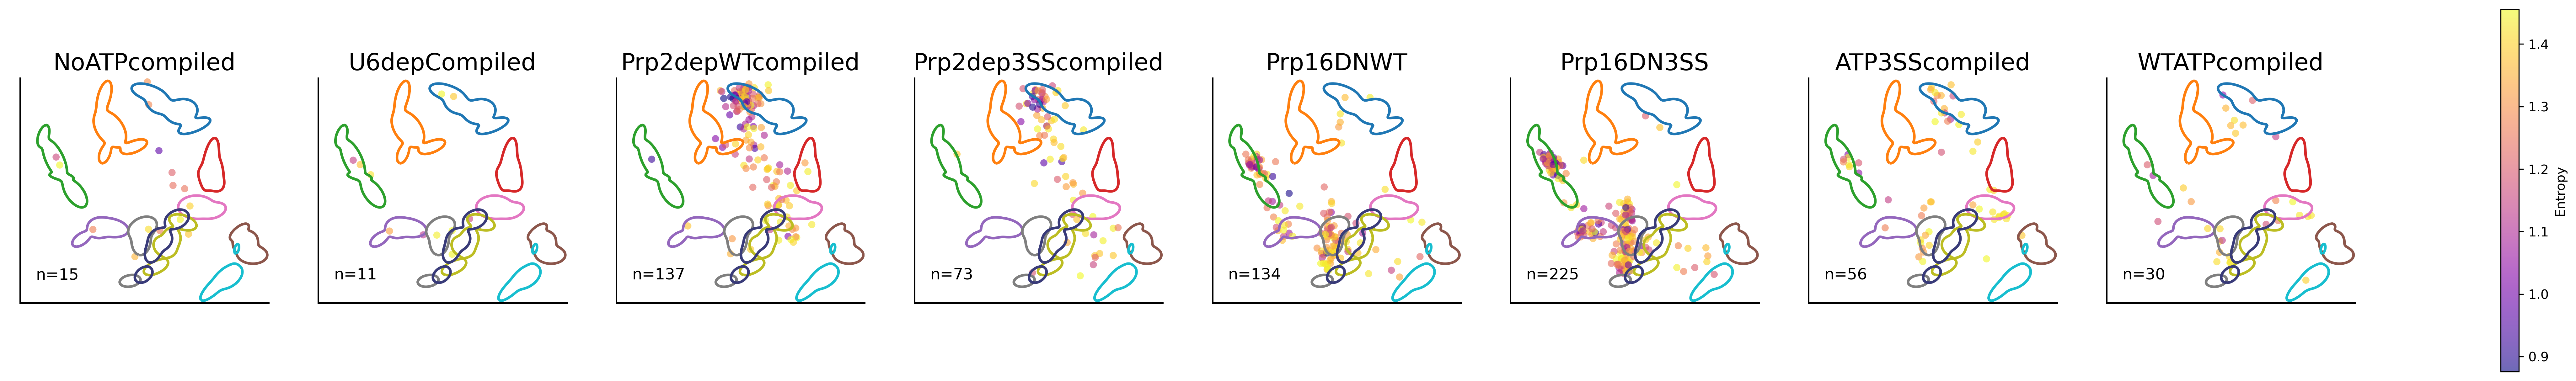

In [15]:
fig, axes = metasim.fret.tools.viz.plot_atlas(
    embedding=embedding_subset,
    label=label_subset,
    color=entropy_subset,
    color_name='Entropy',
    label_order=label_order,
);
plt.savefig('/tmp/fig.svg')

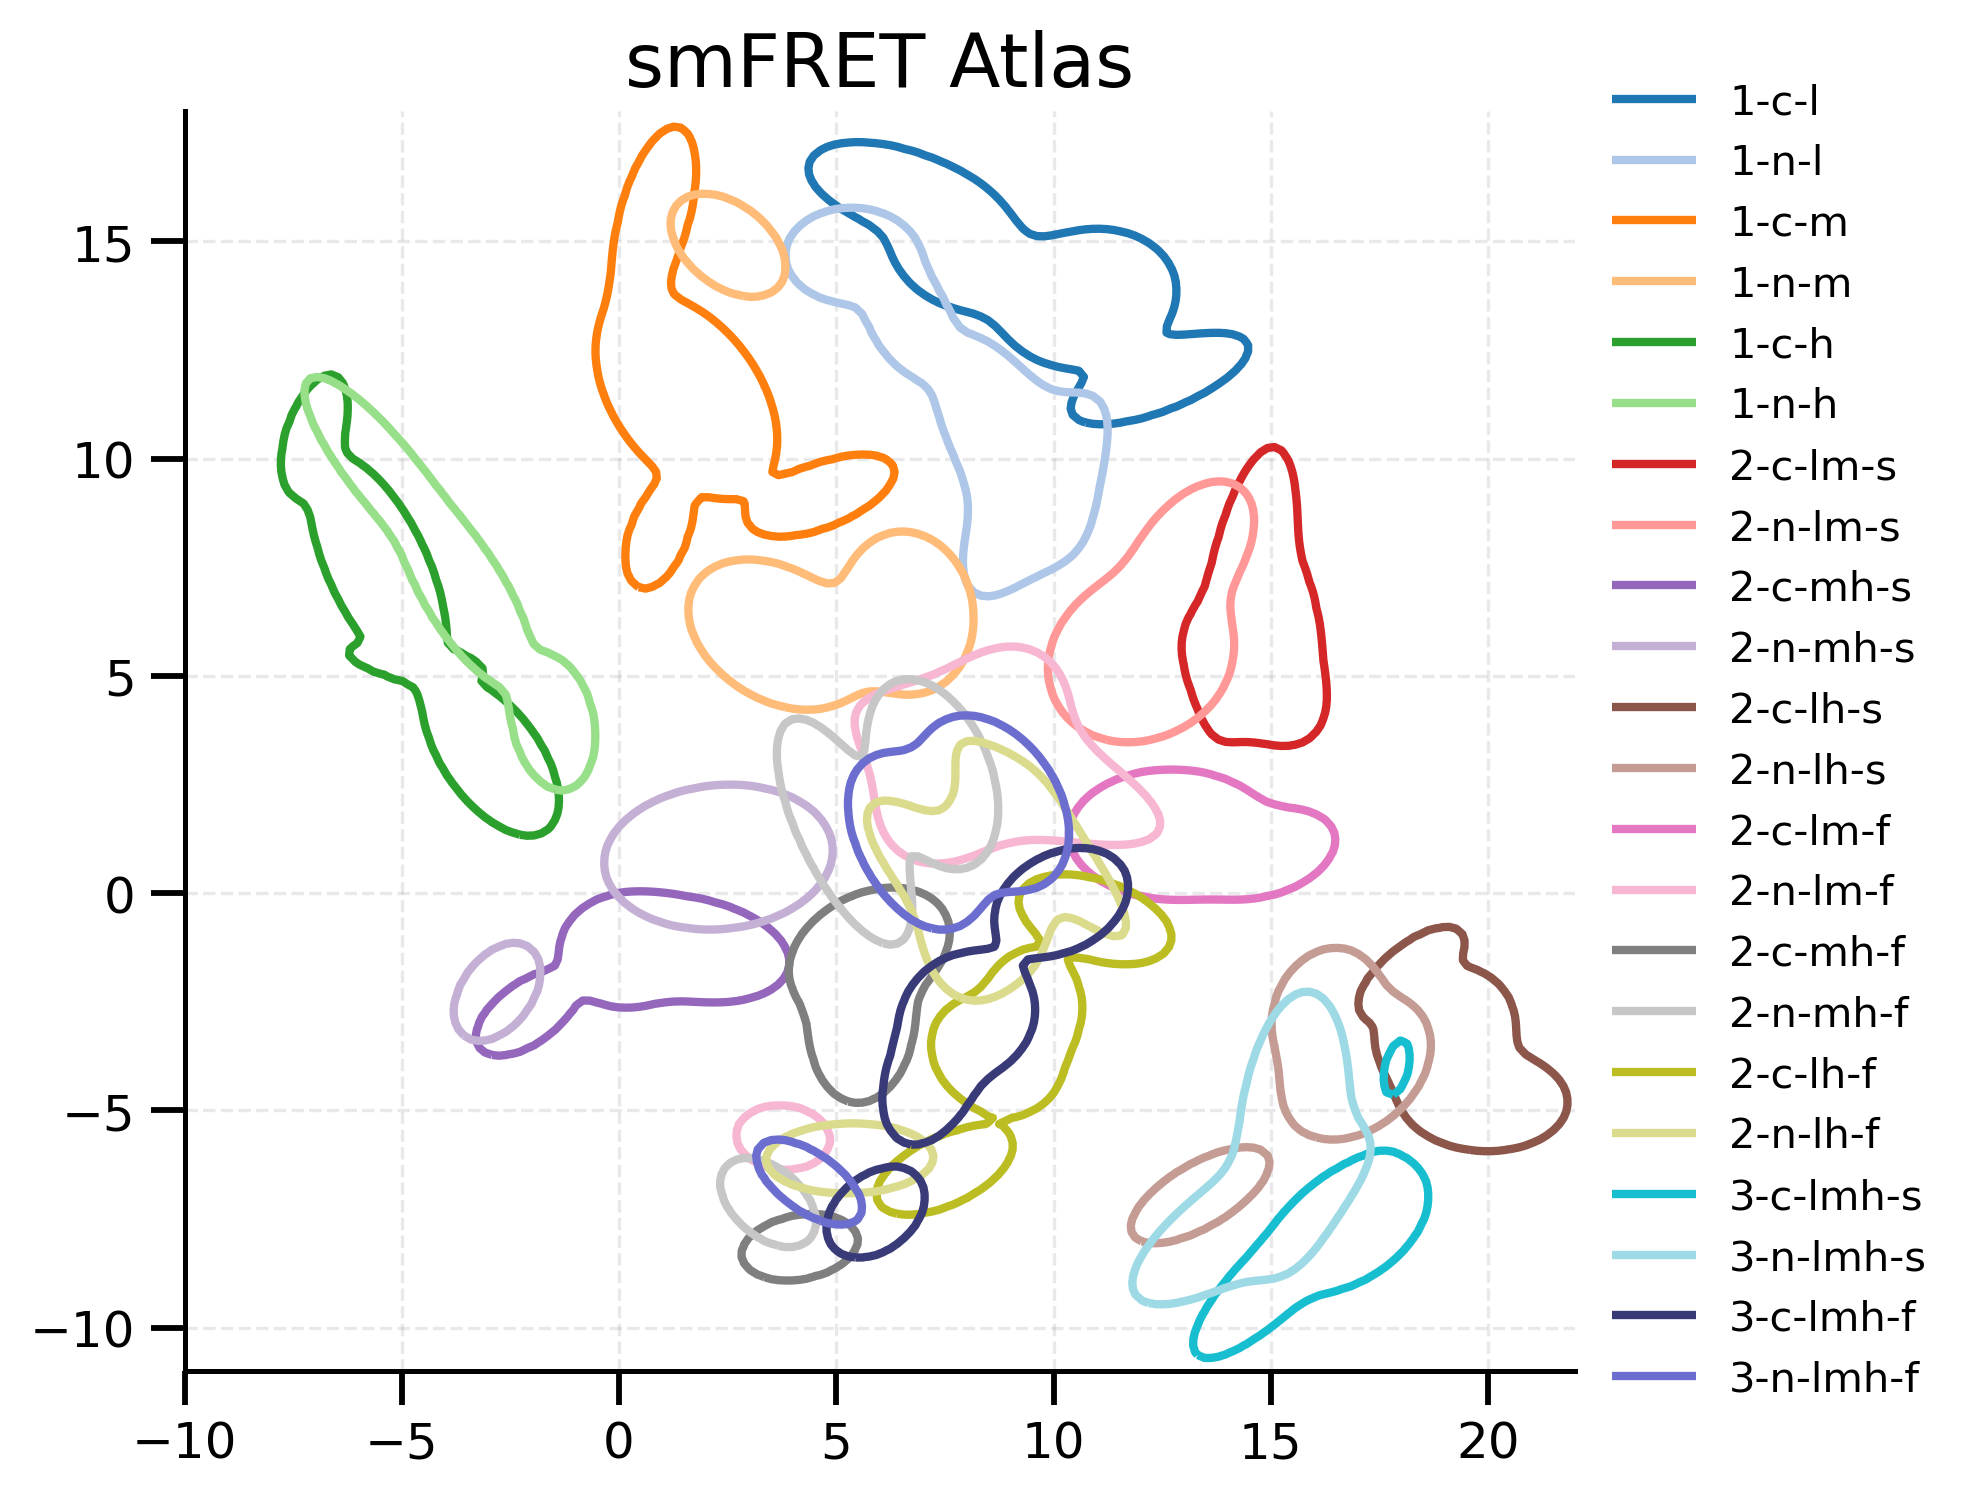

In [14]:
# The Atlas annotations can be hard to remember and read. 
# Sometimes, it's helpful to bring up a reference with all legend in a larger figure.
metasim.fret.tools.viz.plot_atlas_reference()

# System-specific UMAP

Sometimes the global Atlas can hide suttle pattern changes that are not annotated by the Atlas synthetic dataset. Often, these differences can be revealed by building system-specific UMAP, using the dataset alone.


In [8]:
reducer = metasim.fret.tools.viz.get_umap_reducer(embedding)
umap_coord = reducer.transform(embedding)

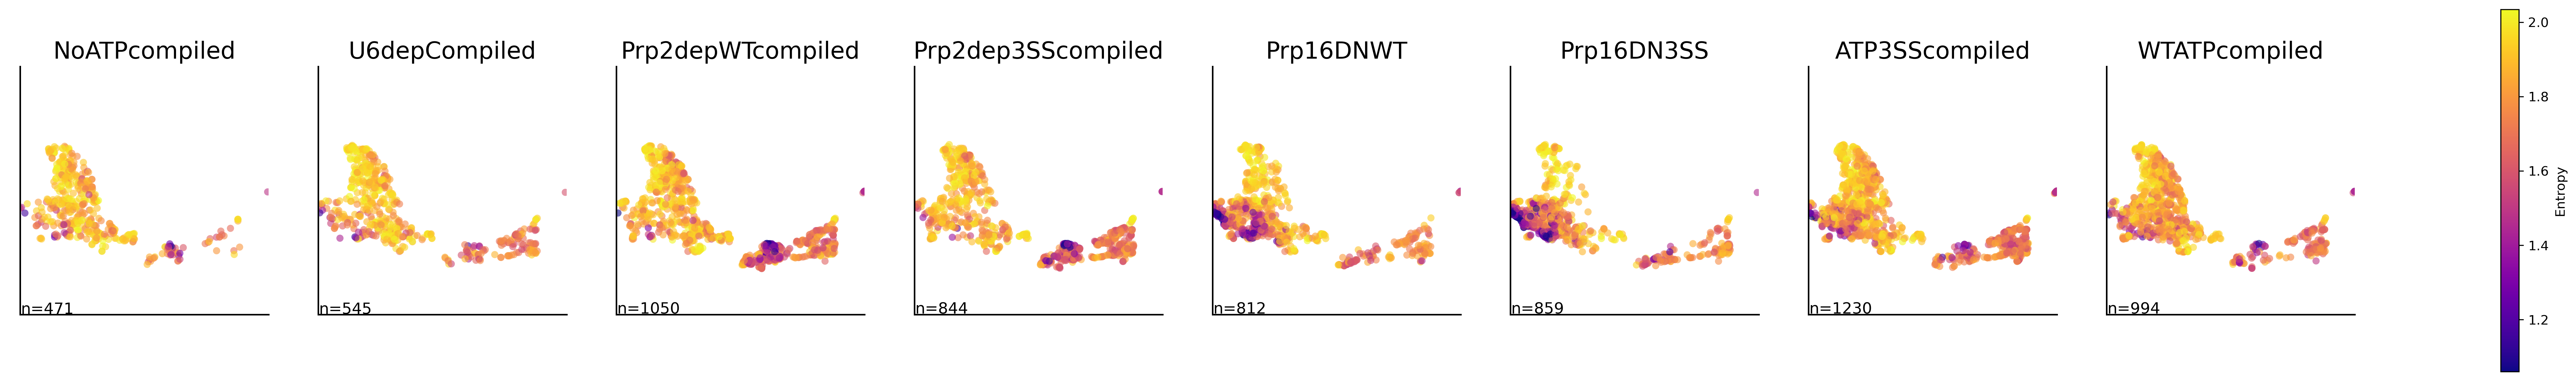

In [9]:
metasim.fret.tools.viz.plot_umap(
    umap_coord=umap_coord,
    label=label,
    color=entropy,
    color_name='Entropy',
    label_order=label_order,
);

## Local Entropy Only

In [10]:
umap_coord_subset = umap_coord[entropy <= entropy_bound, ...]

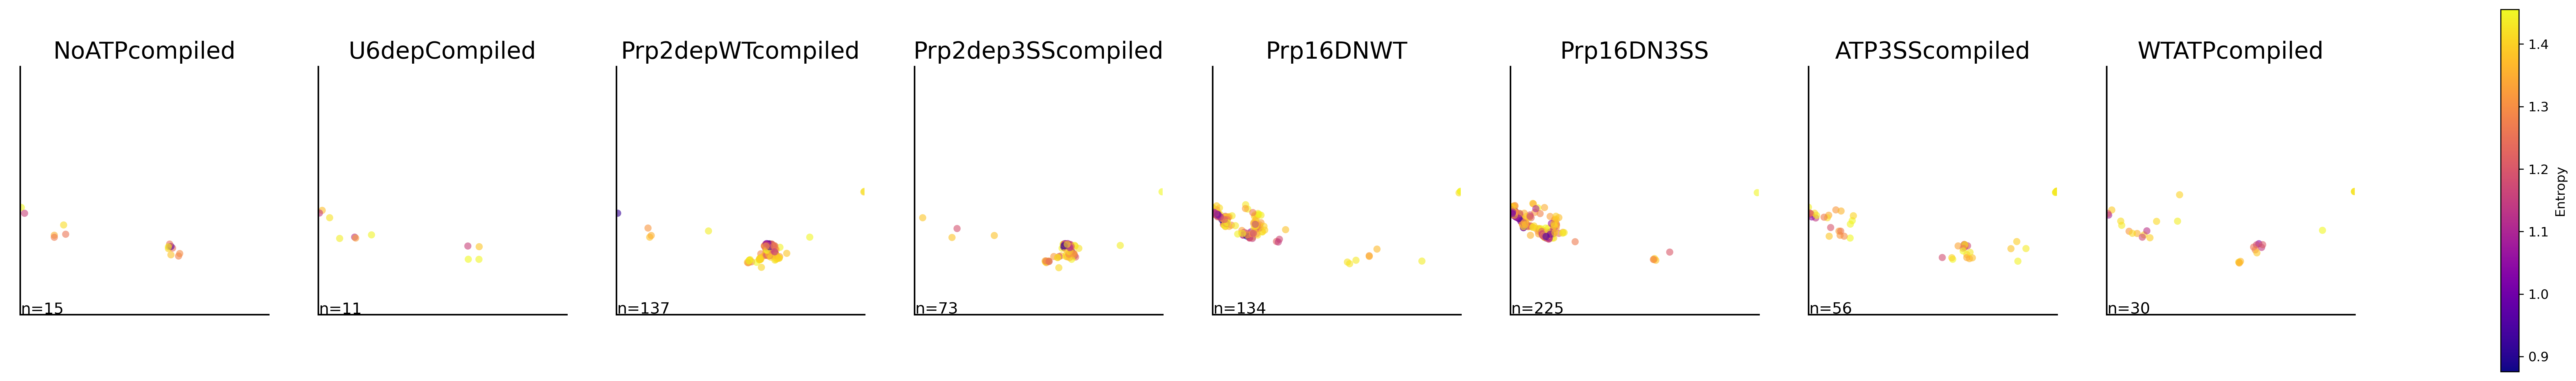

In [11]:
metasim.fret.tools.viz.plot_umap(
    umap_coord=umap_coord_subset,
    label=label_subset,
    color=entropy_subset,
    color_name='Entropy',
    label_order=label_order,
);

# FRET Efficiency Histogram

FRET histogram is a useful tool to extract useful information from traces. META-SiM has a built-in function to calculate FRET histogram. What's novel about this function is that it uses META-SiM model to exclude background zero-FRET frames from the histogram so that you don't need to use other algorithms to exclude background frames.

In [12]:
with tf.device('/CPU:0'):
    idealized_states = metasim.fret.tools.idealize.idealize(dataset)

  0%|          | 0/6805 [00:00<?, ?it/s]

In [13]:
efficiency = metasim.fret.tools.idealize.get_fret_efficiency(
    dataset,
    idealized_states,
)

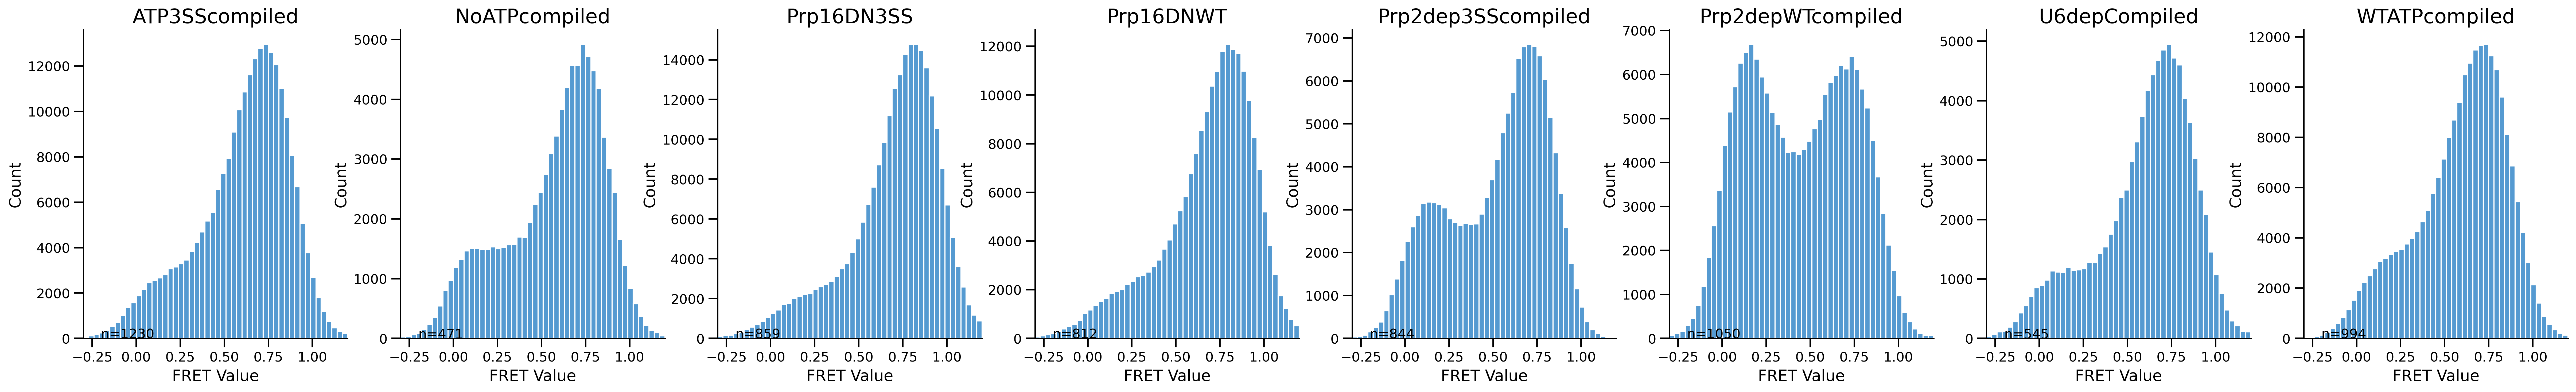

In [14]:
metasim.fret.tools.viz.plot_fret_histograms(
    efficiency,
    label,
);

## Low entropy only

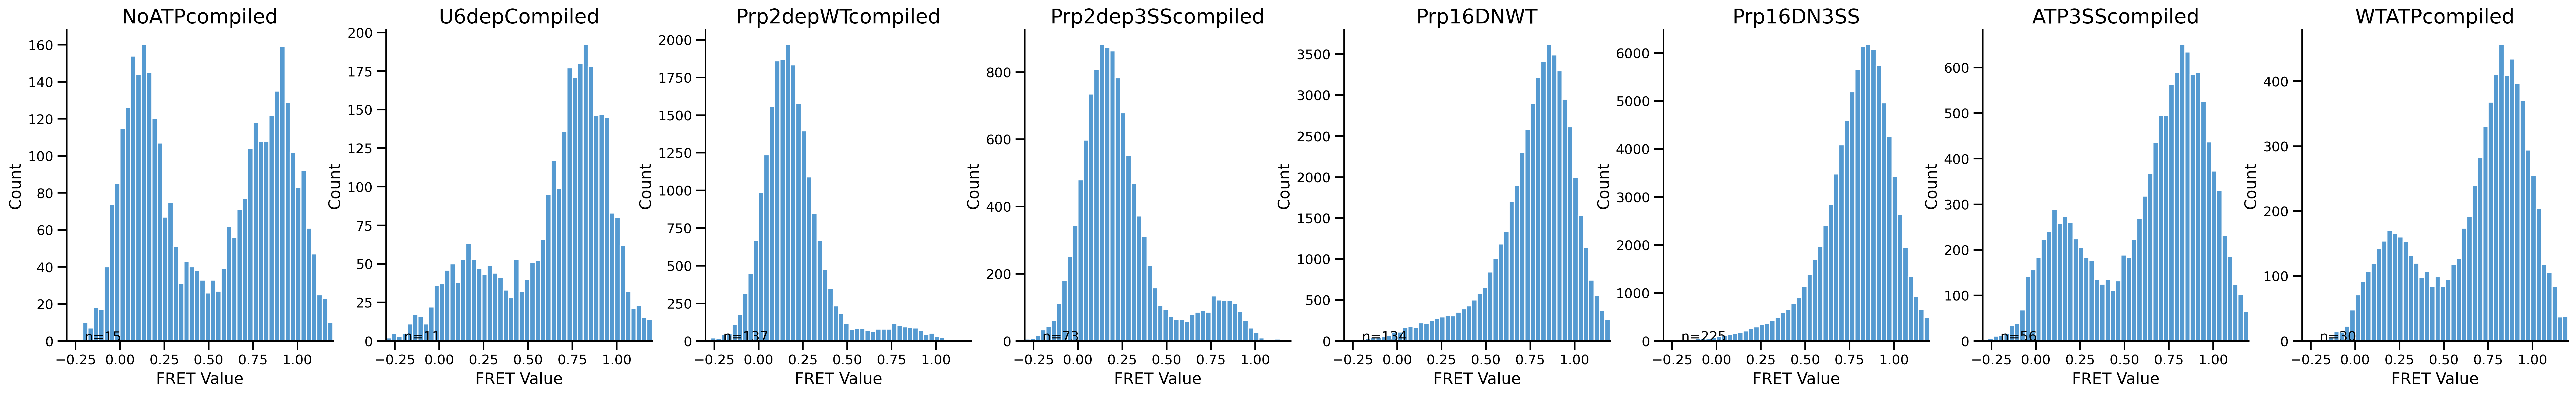

In [15]:
metasim.fret.tools.viz.plot_fret_histograms(
    [e for (i, e) in enumerate(efficiency) if entropy[i] <= entropy_bound],
    label_subset,
    label_order=label_order,
);

# Customize color label of UMAP

 - Sometimes it is helpful to color-code the UMAP scatter points with some properties other than the local shannon entropy.
 - Here, we color-code the UMAP with average FRET efficiency for each trace.
 - To distinguish with the entropy UMAP, we change to a different colormap.

In [16]:
mean_efficiency = []
for e in efficiency:
    if len(e) > 0:
        mean_efficiency.append(np.mean(e))
    else:
        mean_efficiency.append(0)
mean_efficiency = np.array(mean_efficiency)
mean_efficiency_subset = mean_efficiency[entropy < entropy_bound]

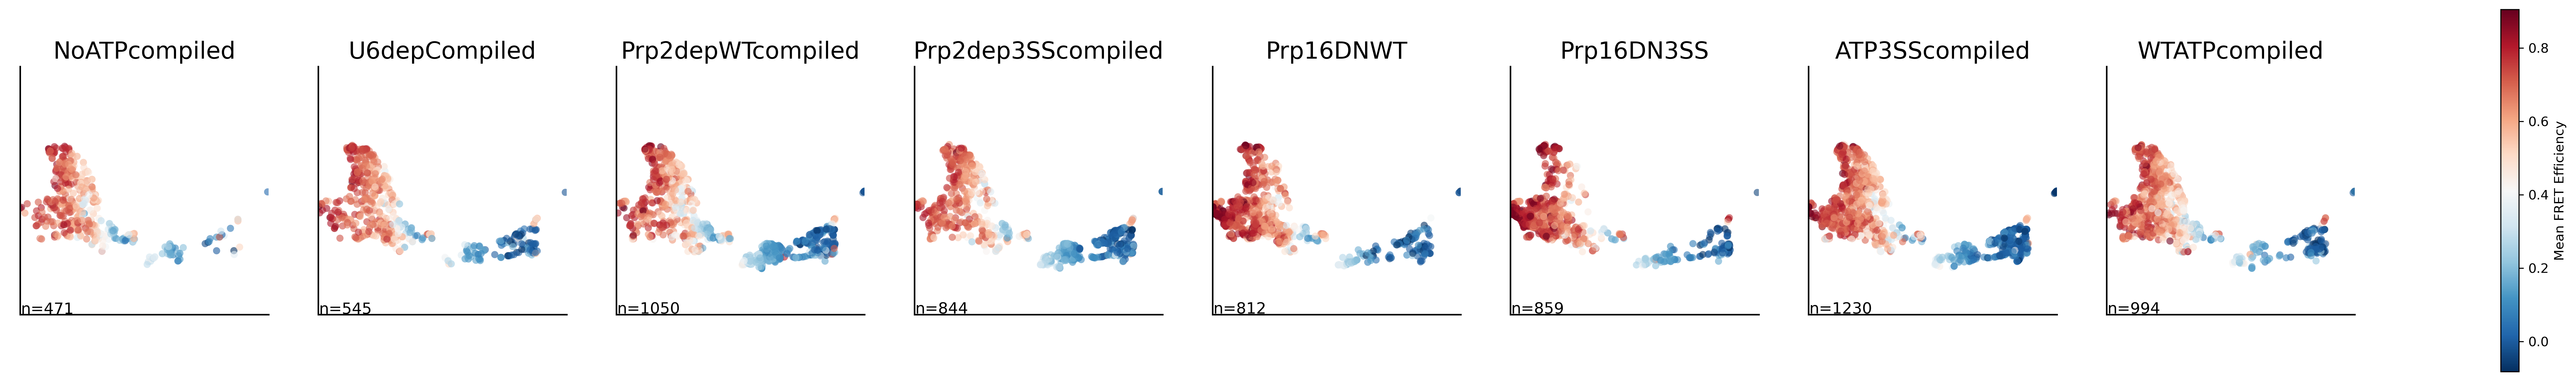

In [17]:
metasim.fret.tools.viz.plot_umap(
    umap_coord=umap_coord,
    label=label,
    color=mean_efficiency,
    color_name='Mean FRET Efficiency',
    color_map='RdBu_r',
    label_order=label_order,
);

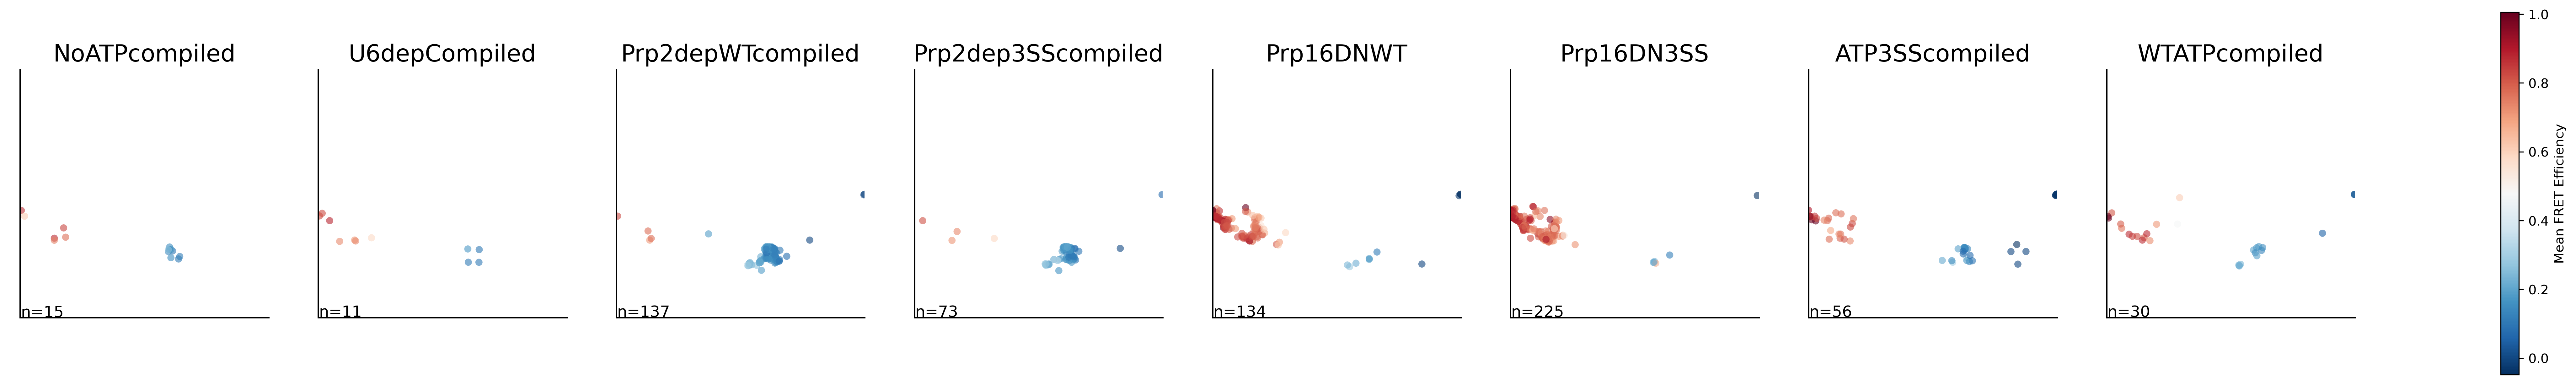

In [18]:
metasim.fret.tools.viz.plot_umap(
    umap_coord=umap_coord_subset,
    label=label_subset,
    color=mean_efficiency_subset,
    color_name='Mean FRET Efficiency',
    color_map='RdBu_r',
    label_order=label_order,
);